# Cross Validation

## Nested Cross Validation: 

- we create different split indexes based time-series with days as unit.
- we implement 3 splitts
- Random Hyper-parameters search 


### Imports

In [1]:
import csv
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow.keras import layers, losses, callbacks, Sequential, optimizers, metrics
from tensorflow.keras.models import Model
from sklearn.pipeline import Pipeline

import pickle
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, roc_auc_score, precision_recall_curve

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib notebook

import wandb
from wandb.keras import WandbCallback

2021-10-02 13:41:11.032347: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-02 13:41:11.032383: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import sys
module_path = sys.path.append('/home/ubuntu/nabu/anomaly_detection/src')
if module_path not in sys.path:
    sys.path.append(module_path)
    
from data import *
from helpers import *
from models import *

In [3]:
RANDOM_SEED = 0

set_seed(RANDOM_SEED)

In [4]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Load Data

In [5]:
DATA = Path('../data')
TRAIN_DATASET = DATA / 'train_data_new.csv'
TEST_DATASET = DATA / 'test_data_new.csv'

df_train = pd.read_csv(TRAIN_DATASET.resolve())
df_test = pd.read_csv(TEST_DATASET.resolve())

df_train.shape
df_test.shape

(1365979, 76)

(282925, 76)

# Best Features: IF

In [8]:
# TODO: save the feature selected .json file and add reading here what 

# read here json 
# best_general_features = read

In [8]:
# IF, IF-KMeans

IF_BEST_FINAL_FEATURES = ['identify',
 'packet_size',
 'country',
 'ip',
 'sensor_id',
 'time_val',
 'tor',
 'agg_session_id_row_count',
 'agg_session_id_packet_size_sum',
 'agg_session_id_packet_size_max']


# NEW
IF_FEATURES_WITHOUT_AGGS = ['identify',
 'packet_size',
 'country',
 'ip',
 'time_val',
 'tor']

IF_BEST_PARAMS = {'n_estimators': 200,
 'max_samples': 'auto',
 'contamination':'auto',
 'max_features': 4,
 'bootstrap': False,
 'n_jobs': -1,
 'random_state': 100}

# AE
AE_BEST_FINAL_FEATURES = ['identify',
 'packet_size',
 'country',
 'ip',
 'sensor_id',
 'time_val',
 'tor',
 'agg_session_id_row_count',
 'agg_session_id_packet_size_sum',
 'agg_session_id_packet_size_max']

# AE_BEST_PARAMS = BATCH_SIZE = 256
# EPOCHS = 100

# pipeline = Pipeline([('normalizer', Normalizer()),
#                      ('scaler', MinMaxScaler())])

# input_dim = df_train[BEST_FINAL_FEATURES].shape[1] - 1 # minus 'identify'
# model_config = {
#     'model_name': 'AutoEncoder', 
#     'input_dim': input_dim,
#     'params': {
#         'optimizer': 'rmsprop',
#         'loss': 'mae',
#         'metrics': ['acc'],
#         'architecture': [256, 36, 16, 8],
#         'learning_rate': 0.001
#     }
# }
# fit_config = {
#     'epochs': EPOCHS,
#     'batch_size': BATCH_SIZE
# }

# DF with all models configrations

df_config = pd.DataFrame(data={'model':['IF', 'IF_KMeans', 'AE'], 
                                'features':[IF_FEATURES_WITHOUT_AGGS,IF_FEATURES_WITHOUT_AGGS,IF_FEATURES_WITHOUT_AGGS], 
                               'params':[IF_BEST_PARAMS,IF_BEST_PARAMS,{}]})



In [9]:
def get_model(model_name: str, params: dict, input_dim: int = 0):
    if model_name == 'IF':
        model = IsolationForest(**params)
    elif model_name == 'IF_KMeans':
        model = IF_KMeans(**params)
    elif model_name == 'AutoEncoder':
        if not input_dim:
            print('Error: you must input input_dim size')
            return None
        model = AutoEncoders(input_dim, params['architecture'])
        model.compile(optimizer=params['optimizer'],
                      loss=params['loss'],
                      metrics=params['metrics'])
    return model


def get_callbacks(model):
    yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

    log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(model.layers)}'

    early_stop = callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0.0001,
        patience=10,
        verbose=1, 
        mode='min',
        restore_best_weights=True
    )

    save_model = callbacks.ModelCheckpoint(
        filepath=f'{model.name}_best_weights.tf',
        save_best_only=True,
        monitor='val_loss',
        verbose=0,
        mode='min'
    )

    return [early_stop, save_model] #, WandbCallback(save_format="tf")]

# Utils

In [38]:
def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)

    return 0.6745 * ad / mad

def use_mad_threshold(model, X, threshold: float=3.5):
    y_prob = -model.score_samples(X)
    z_scores = mad_score(y_prob)
    return z_scores > threshold


def eval_model(X, y, model, is_dl: bool=False, use_mad:bool=False):
    
    if is_dl:
        y_pred = y_prob = model.get_outliers(X) 
    else:  # IF
        if use_mad:
            y_pred = use_mad_threshold(model, X, threshold=1.65)
        else:
            y_pred = model.predict(X)
            y_pred = np.where(y_pred == 1, 0, 1)
        y_prob = -model.score_samples(X)

    
    # get metrics
    _, _, auc_score = get_auc(y, y_prob)
    _, _, aucpr_score = get_aucpr(y, y_prob)
    
    res_scores = {}
    res_scores['auc'] = np.round(auc_score, 3)
    res_scores['aucpr'] = np.round(aucpr_score, 3)
    
    (res_scores['tn'], res_scores['fp'], res_scores['fn'], 
     res_scores['tp']) = confusion_matrix(y, y_pred).ravel()
      
    target_names = ['Normal', 'Anomalies']
    report_dict = classification_report(y, y_pred, target_names=target_names, 
                                        output_dict=True, digits=2)
    for label, values in report_dict.items():
        if type(values) == dict:
            for key, value in values.items():
                res_scores[f'{label}_{key}'] = np.round(value, 3)
        else:
             res_scores[label] = np.round(values, 3)

    
    return res_scores


def split_x_y(df: pd.DataFrame):
    # X-y sets
    to_drop = ['identify']  
    X = df.drop(to_drop, axis=1)
    y = df.identify    
    return X, y


def write_report(results: dict, output_path: Path):
    is_exists =  output_path.exists()
    with output_path.open('a', newline='') as csvfile:
        fieldnames = list(results.keys())
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if not is_exists:
            writer.writeheader()
        writer.writerow(results)
        
        
def save_model(model, output_path: Path):
    with output_path.open('wb') as f:
        pickle.dump(model, f)
        
        
def train_classic_ml(trainset: pd.DataFrame, 
                     testset: pd.DataFrame, 
                     model_config: dict, 
                     comment: str=None,
                     train_normals_only: bool=True,
                     output_path: Path=None,
                     output_model_path: Path=None,
                    use_mad: bool=False):
    print('loading model')
    model = get_model(**model_config)
    
    if train_normals_only: # exclude anomalies
        trainset = trainset.loc[trainset.identify==0]
    X_train, y_train = split_x_y(trainset)
                     
    print('starting training')
    start = datetime.now()
    model.fit(X_train)
    duration = datetime.now() - start
    print(f'train duration took: {duration}')
    if output_model_path:
        save_model(model, output_model_path) 
                     
    X, y = split_x_y(testset)
    print('starting evaluation')
    results = eval_model(X, y, model, use_mad=use_mad)
    results['model_name'] = model_config["model_name"]
    results['train_duration'] = str(duration)
    results['time'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    results['comment'] = comment
    print('done. writing results')
    
    from pprint import pprint
    pprint(results)
    
    if output_path:
        write_report(results, output_path)
    
    return results


def train_dl(trainset: pd.DataFrame, 
             testset: pd.DataFrame, 
             model_config: dict, 
             comment: str=None, 
             fit_config: dict=None, 
             output_path: Path=None, 
             pipeline=None, 
             validation_size=0.2):   
    trainset = trainset.loc[trainset.identify==0]
    training_sample = round(len(trainset) * validation_size)

    X_train = trainset.iloc[:training_sample]
    X_val = trainset.iloc[training_sample:]
    
    if model_config['params']['optimizer'] == 'adam':
        model_config['params']['optimizer'] = optimizers.Adam(learning_rate=model_config['params']['learning_rate'])
    elif model_config['params']['optimizer'] == 'rmsprop':
        model_config['params']['optimizer'] = optimizers.RMSprop(learning_rate=model_config['params']['learning_rate'])
    
    y_train = X_train.pop('identify')
    y_val = X_val.pop('identify')
    y_test = testset.pop('identify')
        
    if pipeline:
        print('transform datasets')
        pipeline.fit(trainset.drop('identify', axis=1))
        X_train = pipeline.transform(X_train)  # check if remove anomalies
        X_val = pipeline.transform(X_val)
        X_test = pipeline.transform(testset)
    else:
        X_test = testset
    
    print('loading model')
    model = get_model(**model_config)
    cb = get_callbacks(model)
    
    print('starting training')   
    start = datetime.now()
    history = model.fit(
        X_train, X_train,
        shuffle=True,
        epochs=fit_config['epochs'],
        batch_size=fit_config['batch_size'],
        callbacks=cb,
        validation_data=(X_val, X_val)
    )
    duration = datetime.now() - start
    print(f'train duration took: {duration}')
    
    results = eval_model(X_test, y_test, model, is_dl=True)
    results['model_name'] = model_config['model_name']
    results['train_duration'] = duration
    results['time'] = str(datetime.now())
    results['comment'] = comment
                     
    print('done. writing results')
    if output_path:
        write_report(results, output_path)
    return results

def train(trainset, testset, model_config, comment, fit_config, pipeline=None):
    if model_config['model_name'] in ('IF', 'IF_KMeans'):
        return train_classic_ml(trainset,
                                testset, 
                                model_config, 
                                comment)
    elif model_config['model_name'] in ('AutoEncoder'):
        return train_dl(trainset, 
                        testset, 
                        model_config, 
                        comment, 
                        fit_config, 
                        pipeline=pipeline)
    else: 
        raise ValueError(f"{model_config['model_name']} not supported") 

def ts_split(df):
    '''this function splits and chooses indexes for several train and test sets based on days unit
    and in chronological order. i.e. test set follows the train set by days. 
    Then, the next train-test sets will be the train set before and the new test set will be the one that follows.a
    returns the dictionary cv_splits. 
    For each cv_i we have:
    1. the end index of train set (train set starts always from 0)
    2. start index of test set follows in chronological order the train set
    3. the end index of test set which is: test start index + test_size_days '''
    
    # Create dictionary of cv splits
    test_size_days = 3  # that is the test set window based on days
    test_ind_start = 17  # the first train set will be from size: test_ind_start-1
    test_ind_end = test_ind_start + test_size_days 
    df.ts = pd.to_datetime(df.ts)
    n_days = df.ts.dt.date.nunique()
    arr_days  = df.ts.dt.date.unique()

    cv_splits = {}
    cv_i = 0
    while test_ind_end <= n_days:
        cv_splits[cv_i] = {'train_end': arr_days[test_ind_start-1],
                       'test_start': arr_days[test_ind_start],
                       'test_end': arr_days[test_ind_end-1],} 
        # update indexes
        test_ind_start = test_ind_end 
        test_ind_end = test_ind_start + test_size_days
        cv_i += 1
    return cv_splits


def generate_params(param_grid):
    '''generate random sample from grid search'''
    
    from random import sample
    
    param_res = {}
    for p in param_grid:
        param_res[p] = sample(param_grid[p], 1)[0]
    return param_res


def classes_counts_train_test(df_train, df_test):

    print('\nTrain Set:')
    print('\nValue Counts')
    print(df_train.identify.value_counts())
    print('\nValue Counts (%)')
    print(df_train.identify.value_counts(normalize=True)*100)

    print('\n--------------------------------')
    print('\nValidation Set:')
    print('\nValue Counts')
    print(df_test.identify.value_counts())
    print('\nValue Counts (%)')
    print(df_test.identify.value_counts(normalize=True)*100)
    print('\n--------------------------------')

# Models Evaluation

### Saving Data Frame of CV results to .csv file

# Best Hyper-Parameters

# IF

# Train and Save Final Models 

In [39]:
model_key = df_config[df_config.model == 'IF']  # IF, IF_KMeans, AE
model_name = model_key['model'].values[0]
model_features = model_key['features'].values[0]
model_params = model_key['params'].values[0]

output_dir = Path('/home/ubuntu/nabu/anomaly_detection/outputs')
yyyymmddHHMMSS = datetime.now().strftime('%Y%m%d%H%M%S')
output_path = output_dir / f'{model_name}_final_results{yyyymmddHHMMSS}.csv'
output_model_path = output_dir / f'{model_name}_final_model{yyyymmddHHMMSS}.pkl'

save_flag = False
if not save_flag:
    output_path = None
    output_model_path = None
    
# Fit with final selected features
model_config = {'model_name': model_name,
                   'params': model_params}

# train with best parameters:
results = train_classic_ml(df_train[model_features], df_test[model_features], 
    model_config, comment=f'the final {model_name} with best Hyper-parameters', 
                 output_path=output_path, output_model_path=output_model_path, use_mad=True)


loading model
starting training
train duration took: 0:00:01.929213
starting evaluation
done. writing results
{'Anomalies_f1-score': 0.003,
 'Anomalies_precision': 0.002,
 'Anomalies_recall': 0.932,
 'Anomalies_support': 74,
 'Normal_f1-score': 0.914,
 'Normal_precision': 1.0,
 'Normal_recall': 0.841,
 'Normal_support': 282851,
 'accuracy': 0.841,
 'auc': 0.89,
 'aucpr': 0.001,
 'comment': 'the final IF with best Hyper-parameters',
 'fn': 5,
 'fp': 44967,
 'macro avg_f1-score': 0.458,
 'macro avg_precision': 0.501,
 'macro avg_recall': 0.887,
 'macro avg_support': 282925,
 'model_name': 'IF',
 'time': '2021-10-02 14:28:18',
 'tn': 237884,
 'tp': 69,
 'train_duration': '0:00:01.929213',
 'weighted avg_f1-score': 0.913,
 'weighted avg_precision': 1.0,
 'weighted avg_recall': 0.841,
 'weighted avg_support': 282925}


In [37]:
results

{'auc': 0.89,
 'aucpr': 0.001,
 'tn': 234154,
 'fp': 48697,
 'fn': 3,
 'tp': 71,
 'Normal_precision': 1.0,
 'Normal_recall': 0.828,
 'Normal_f1-score': 0.906,
 'Normal_support': 282851,
 'Anomalies_precision': 0.001,
 'Anomalies_recall': 0.959,
 'Anomalies_f1-score': 0.003,
 'Anomalies_support': 74,
 'accuracy': 0.828,
 'macro avg_precision': 0.501,
 'macro avg_recall': 0.894,
 'macro avg_f1-score': 0.454,
 'macro avg_support': 282925,
 'weighted avg_precision': 1.0,
 'weighted avg_recall': 0.828,
 'weighted avg_f1-score': 0.906,
 'weighted avg_support': 282925,
 'model_name': 'IF',
 'train_duration': '0:00:01.995766',
 'time': '2021-10-02 14:15:30',
 'comment': 'the final IF with best Hyper-parameters'}

In [43]:
results

{'auc': 0.89,
 'aucpr': 0.001,
 'tn': 242067,
 'fp': 40784,
 'fn': 3,
 'tp': 71,
 'Normal_precision': 1.0,
 'Normal_recall': 0.856,
 'Normal_f1-score': 0.922,
 'Normal_support': 282851,
 'Anomalies_precision': 0.002,
 'Anomalies_recall': 0.959,
 'Anomalies_f1-score': 0.003,
 'Anomalies_support': 74,
 'accuracy': 0.856,
 'macro avg_precision': 0.501,
 'macro avg_recall': 0.908,
 'macro avg_f1-score': 0.463,
 'macro avg_support': 282925,
 'weighted avg_precision': 1.0,
 'weighted avg_recall': 0.856,
 'weighted avg_f1-score': 0.922,
 'weighted avg_support': 282925,
 'model_name': 'IF',
 'train_duration': '0:00:01.875075',
 'time': '2021-10-02 13:21:53',
 'comment': 'the final IF with best Hyper-parameters'}

## IF-KMean
a. 'n_estimators' =  
b. 'max_samples' =  
c. 'contamination' =   
d. 'max_features' =   
e. 'bootstrap' =  
    
We tune IF and then the chosen hyperparameters we use for IF-Kmeans. 
Then, we tune the Kmeans layer with the following hyperparameters: max_iter
Hyperparameters tuning :   
a. max_iter

In [39]:
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest

class IF_KMeans(IsolationForest):
    
    def __init__(self,  *args, **kwargs):
        super(IF_KMeans, self).__init__(*args, **kwargs)
#         self.IF_model = IsolationForest(*args, **kwargs)
        self.KMeans_model = KMeans(n_clusters=2)
        
        
    def fit(self, X):
        print('Fitting the Isolation Forest model...')
        super().fit(X)
        self.anomaly_scores = -super().score_samples(X)  # sklearn Opposite of the anomaly score defined in the original 
        print('Fitting K-Means on the Anomaly Scores...')
        self.KMeans_model.fit(self.anomaly_scores.reshape(-1, 1))
        
        
    def predict(self, X):
        _pred = -super().score_samples(X)
        return model.KMeans_model.predict(_pred.reshape(-1, 1))

# Train IF-KMeans

In [61]:

    
x_train, y_train = split_x_y(df_train[selected_features])
x_test, y_test = split_x_y(df_test[selected_features])


# Initialize Model 

# model=IF_KMeans(**best_params_no_aggs)
model = IsolationForest(**best_params_no_aggs)

# Train
model.fit(x_train)

# Predict on Test 
y_pred = model.predict(x_test)
y_pred = np.where(y_pred == 1, 0, 1)
y_prob = -model.score_samples(x_test)
y_pred_mad = use_mad_threshold(model, x_test)

IsolationForest(max_features=4, n_estimators=200, n_jobs=-1, random_state=100)

IF using MAD Threshold


<IPython.core.display.Javascript object>


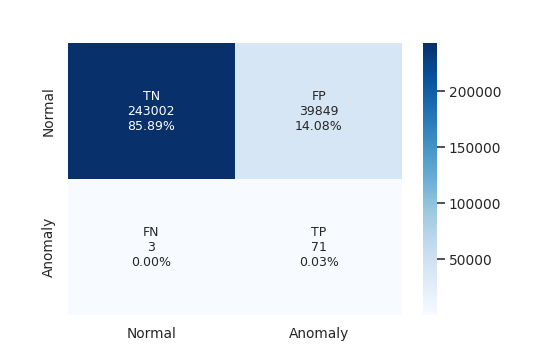

In [76]:
y_pred_mad = use_mad_threshold(model, x_test, threshold=1.8)
print('IF using MAD Threshold')
plot_confusion_matrix(y_test, y_pred_mad)

In [51]:
model_config = {'model_name': 'IF',
 'params': {'n_estimators': 200,
  'max_samples': 'auto',
  'contamination': 'auto',
  'max_features': 4,
  'bootstrap': False,
  'n_jobs': -1,
  'random_state': 100}}

output_dir = Path('/home/ubuntu/nabu/anomaly_detection/outputs')
yyyymmddHHMMSS = datetime.now().strftime('%Y%m%d%H%M%S')
output_path = output_dir / f'{model_config["model_name"]}_IF_KMeans_model_results_no_aggs_{yyyymmddHHMMSS}.csv'
output_model_path = output_dir / f'{model_config["model_name"]}_IF_KMeans_model_no_aggs_{yyyymmddHHMMSS}.pkl'

not_saving = True
if not_saving:
    output_path = None
    output_model_path = None

# train with best parameters:
results = train_classic_ml(df_train[NEW_FEATURES], df_test[NEW_FEATURES], 
    model_config, comment='final IF with best Hyper-parameters and no aggs features', 
                 output_path=output_path, output_model_path=output_model_path)


loading model
starting training
train duration took: 0:00:01.877214
starting evaluation


KeyboardInterrupt: 

## AutoEncoder
Batch Size: 256-1000  
Hyperparameters tuning :  
    a. Optimizer: Adam/RMSProp  
    b. Objective Function: RMSE/MSE  
    c. Layers number: a. as in the paper. (7 layer) b. more hidden layers (9 layers)  
    d. Number of neurons in the layers: a. as in the paper. ([|#Features|, 140, 35, 16, 16, 35, |#Features|]) ,([|#Features|, 256, 36, 16, 8, 16, 36, 256,|#Features|])   
    e. Learning rate: 0.1, 0.01, 0.001

In [26]:
BATCH_SIZE = 256
EPOCHS = 100

pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [27]:
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [28]:
input_dim = df_train[BEST_FINAL_FEATURES].shape[1] - 1 # minus 'identify'
model_config = {
    'model_name': 'AutoEncoder', 
    'input_dim':input_dim
}
fit_config = {
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE
}

params_grid = {
   'optimizer': ['adam','rmsprop'],
   'loss': [root_mean_squared_error, 'mse', 'mae'],
   'metrics': [["acc"]],
   'architecture': [
       [140, 35, 16, 16],
       [256, 36, 16, 8]
   ],
   'learning_rate': [0.1, 0.01, 0.001]
}

# For output file:
output_dir = Path('/home/ubuntu/nabu/anomaly_detection/outputs')

In [29]:
cv_dict, best_params = cross_validation(params_grid,
                                         df_train[BEST_FINAL_FEATURES + ['ts']], 
                                         df_test[BEST_FINAL_FEATURES + ['ts']],
                                         model_config, 
                                         output_dir,
                                         max_iter=5,
                                         fit_config=fit_config,
                                         pipeline=pipeline)

/home/ubuntu/pyenv/lib/python3.8/site-packages/pandas/core/generic.py:5507: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Parameters Random Search iterate number 1
sampled params are: {'optimizer': 'rmsprop', 'loss': 'mae', 'metrics': ['acc'], 'architecture': [256, 36, 16, 8], 'learning_rate': 0.01, 'random_state': 100}
CV iterate number 1
train set size: (755588, 11), val set size: (172173, 11)
transform datasets
loading model
starting training
Epoch 1/100
590/590 [==============================] - 47s 5ms/step - loss: 0.0505 - acc: 0.9864 - val_loss: 0.0107 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 2/100
590/590 [==============================] - 3s 5ms/step - loss: 0.0272 - acc: 0.9966 - val_loss: 0.0140 - val_acc: 0.9999
Epoch 3/100
590/590 [==============================] - 3s 5ms/step - loss: 0.0224 - acc: 0.9983 - val_loss: 0.0162 - val_acc: 0.9999
Epoch 4/100
590/590 [==============================] - 3s 5ms/step - loss: 0.0240 - acc: 1.0000 - val_loss: 0.0070 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets

### Best Hyper-Parameters

In [24]:
best_
params

{'optimizer': <keras.optimizer_v2.rmsprop.RMSprop at 0x7fe70331a490>,
 'loss': <function keras.losses.mean_squared_error(y_true, y_pred)>,
 'metrics': ['acc'],
 'architecture': [9, 256, 36, 16, 8, 16, 36, 256, 9],
 'learning_rate': 0.1,
 'random_state': 100}

In [42]:
[(cv_dict[cv_i]['mean_results'], cv_dict[cv_i]['params']) for cv_i in cv_dict]

[({'auc': 0.8805000000000001,
   'aucpr': 0.44525,
   'tn': 196661.75,
   'fp': 26562.5,
   'fn': 11.5,
   'tp': 93.25,
   'Normal_precision': 1.0,
   'Normal_recall': 0.87275,
   'Normal_f1-score': 0.93125,
   'Normal_support': 223224.25,
   'Anomalies_precision': 0.0035,
   'Anomalies_recall': 0.8875,
   'Anomalies_f1-score': 0.0072499999999999995,
   'Anomalies_support': 104.75,
   'accuracy': 0.87275,
   'macro avg_precision': 0.502,
   'macro avg_recall': 0.8805000000000001,
   'macro avg_f1-score': 0.46925,
   'macro avg_support': 223329.0,
   'weighted avg_precision': 0.99925,
   'weighted avg_recall': 0.87275,
   'weighted avg_f1-score': 0.931,
   'weighted avg_support': 223329.0},
  {'optimizer': <keras.optimizer_v2.rmsprop.RMSprop at 0x7fe70306feb0>,
   'loss': <function keras.losses.mean_squared_error(y_true, y_pred)>,
   'metrics': ['acc'],
   'architecture': [9, 140, 35, 16, 16, 35, 9],
   'learning_rate': 0.001,
   'random_state': 100}),
 ({'auc': 0.8955,
   'aucpr': 0.46

In [30]:
best_params

{'optimizer': <keras.optimizer_v2.rmsprop.RMSprop at 0x7feb841865b0>,
 'loss': 'mae',
 'metrics': ['acc'],
 'architecture': [256, 36, 16, 8],
 'learning_rate': 0.001,
 'random_state': 100}

In [31]:
[(cv_dict[cv_i]['mean_results'], cv_dict[cv_i]['params']) for cv_i in cv_dict]

[({'auc': 0.8747499999999999,
   'aucpr': 0.46725,
   'tn': 181317.25,
   'fp': 41907.0,
   'fn': 7.25,
   'tp': 97.5,
   'Normal_precision': 1.0,
   'Normal_recall': 0.817,
   'Normal_f1-score': 0.89725,
   'Normal_support': 223224.25,
   'Anomalies_precision': 0.0032500000000000003,
   'Anomalies_recall': 0.93225,
   'Anomalies_f1-score': 0.00625,
   'Anomalies_support': 104.75,
   'accuracy': 0.817,
   'macro avg_precision': 0.5015000000000001,
   'macro avg_recall': 0.8747499999999999,
   'macro avg_f1-score': 0.45199999999999996,
   'macro avg_support': 223329.0,
   'weighted avg_precision': 0.9995,
   'weighted avg_recall': 0.817,
   'weighted avg_f1-score': 0.897,
   'weighted avg_support': 223329.0},
  {'optimizer': <keras.optimizer_v2.rmsprop.RMSprop at 0x7feb44beba00>,
   'loss': 'mae',
   'metrics': ['acc'],
   'architecture': [256, 36, 16, 8],
   'learning_rate': 0.01,
   'random_state': 100}),
 ({'auc': 0.89175,
   'aucpr': 0.46950000000000003,
   'tn': 191296.75,
   'fp':

In [26]:
# read json 
# calculate average again:
scores_arr = cv_dict[0]['mean_results'].keys()
avg_results = {}
sum_scores = 0
cv_splits = 4

for cv_i in cv_dict:
    avg_results[cv_i] = {}
    avg_results[cv_i]['params'] = cv_dict[cv_i]['params']
    for score in scores_arr:
        sum_scores = 0
        for res in cv_dict[cv_i]['cv_results']:
            sum_scores += res[score]
        avg_results[cv_i][score] = sum_scores/cv_splits
    



cv_results_df = pd.DataFrame(avg_results).T
cv_results_df = cv_results_df.reset_index().rename(columns={'index':'cv_i'})

cv_results_df

,cv_i,params,auc,aucpr,tn,fp,fn,tp,Normal_precision,Normal_recall,...,Anomalies_support,accuracy,macro avg_precision,macro avg_recall,macro avg_f1-score,macro avg_support,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,weighted avg_support
0,0,{'optimizer': <keras.optimizer_v2.rmsprop.RMSp...,0.8805,0.44525,196661.75,26562.5,11.5,93.25,1.0,0.87275,...,104.75,0.87275,0.502,0.8805,0.46925,223329.0,0.99925,0.87275,0.931,223329.0
1,1,{'optimizer': <keras.optimizer_v2.adam.Adam ob...,0.8955,0.46625,193727.5,29496.75,7.5,97.25,1.0,0.861,...,104.75,0.86125,0.5015,0.8955,0.4655,223329.0,0.9995,0.86125,0.9245,223329.0
2,2,{'optimizer': <keras.optimizer_v2.rmsprop.RMSp...,0.9005,0.469,195988.5,27235.75,6.5,98.25,1.0,0.86525,...,104.75,0.8655,0.50175,0.9005,0.467,223329.0,0.9995,0.8655,0.926,223329.0
3,3,{'optimizer': <keras.optimizer_v2.rmsprop.RMSp...,0.87975,0.44325,197879.5,25344.75,12.5,92.25,1.0,0.87625,...,104.75,0.87625,0.50225,0.87975,0.47025,223329.0,0.99925,0.87625,0.9325,223329.0
4,4,{'optimizer': <keras.optimizer_v2.rmsprop.RMSp...,0.69225,0.4805,207743.0,15481.25,51.5,53.25,0.99975,0.92475,...,104.75,0.9245,0.50075,0.69225,0.481,223329.0,0.99925,0.9245,0.95875,223329.0


In [34]:
best_param_res = cv_results_df.iloc[(cv_results_df['auc']).astype(float).argmax()]

In [35]:
best_param_res['params']

{'optimizer': <keras.optimizer_v2.rmsprop.RMSprop at 0x7fe7029eacd0>,
 'loss': 'mse',
 'metrics': ['acc'],
 'architecture': [9, 256, 36, 16, 8, 16, 36, 256, 9],
 'learning_rate': 0.01,
 'random_state': 100}

In [36]:
best_param_res

cv_i                                                                      2
params                    {'optimizer': <keras.optimizer_v2.rmsprop.RMSp...
auc                                                                  0.9005
aucpr                                                                 0.469
tn                                                                 195988.5
fp                                                                 27235.75
fn                                                                      6.5
tp                                                                    98.25
Normal_precision                                                        1.0
Normal_recall                                                       0.86525
Normal_f1-score                                                     0.92675
Normal_support                                                    223224.25
Anomalies_precision                                                 0.00375
Anomalies_re

### Full Train

In [9]:
BATCH_SIZE = 256
EPOCHS = 100

pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

input_dim = df_train[BEST_FINAL_FEATURES].shape[1] - 1 # minus 'identify'
model_config = {
    'model_name': 'AutoEncoder', 
    'input_dim': input_dim,
    'params': {
        'optimizer': 'rmsprop',
        'loss': 'mae',
        'metrics': ['acc'],
        'architecture': [256, 36, 16, 8],
        'learning_rate': 0.001
    }
}
fit_config = {
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE
}

In [10]:
ae_result = train(df_train[BEST_FINAL_FEATURES], df_test[BEST_FINAL_FEATURES], model_config, comment='full train', fit_config=fit_config, pipeline=pipeline)
ae_result

transform datasets
loading model
starting training
Epoch 1/100


2021-10-02 08:58:22.071339: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-02 08:58:22.071372: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-02 08:58:22.071392: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-16-27): /proc/driver/nvidia/version does not exist
2021-10-02 08:58:22.071593: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-02 08:58:22.234564: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLI

1067/1067 [==============================] - 6s 5ms/step - loss: 0.0150 - acc: 0.9988 - val_loss: 0.0105 - val_acc: 0.9999


2021-10-02 08:58:28.821058: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 2/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0070 - acc: 0.9997 - val_loss: 0.0071 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 3/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0056 - acc: 0.9997 - val_loss: 0.0045 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 4/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0051 - acc: 0.9997 - val_loss: 0.0068 - val_acc: 0.9999
Epoch 5/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0047 - acc: 0.9997 - val_loss: 0.0045 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 6/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0042 - acc: 0.9997 - val_loss: 0.0044 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencode

{'auc': 0.856,
 'aucpr': 0.5,
 'tn': 201108,
 'fp': 81743,
 'fn': 0,
 'tp': 74,
 'Normal_precision': 1.0,
 'Normal_recall': 0.711,
 'Normal_f1-score': 0.831,
 'Normal_support': 282851,
 'Anomalies_precision': 0.001,
 'Anomalies_recall': 1.0,
 'Anomalies_f1-score': 0.002,
 'Anomalies_support': 74,
 'accuracy': 0.711,
 'macro avg_precision': 0.5,
 'macro avg_recall': 0.856,
 'macro avg_f1-score': 0.416,
 'macro avg_support': 282925,
 'weighted avg_precision': 1.0,
 'weighted avg_recall': 0.711,
 'weighted avg_f1-score': 0.831,
 'weighted avg_support': 282925,
 'model_name': 'AutoEncoder',
 'train_duration': datetime.timedelta(seconds=169, microseconds=135146),
 'time': '2021-10-02 09:01:16.399831',
 'comment': 'full train'}

In [11]:
model_config['input_dim'] = df_train[FEATURES_WITHOUT_AGGS].shape[1] - 1 # minus 'identify'
ae_result_without_agg = train(df_train[FEATURES_WITHOUT_AGGS], df_test[FEATURES_WITHOUT_AGGS], model_config, comment='full train', fit_config=fit_config, pipeline=pipeline)

transform datasets
loading model
starting training
Epoch 1/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0216 - acc: 0.9990 - val_loss: 0.0134 - val_acc: 0.9995
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 2/100
1067/1067 [==============================] - 5s 5ms/step - loss: 0.0093 - acc: 1.0000 - val_loss: 0.0116 - val_acc: 0.9995
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 3/100
1067/1067 [==============================] - 5s 5ms/step - loss: 0.0076 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0.9995
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 4/100
1067/1067 [==============================] - 5s 5ms/step - loss: 0.0068 - acc: 1.0000 - val_loss: 0.0071 - val_acc: 0.9995
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 5/100
1067/1067 [==============================] - 5s 5ms/step - loss: 0.0061 - acc: 1.0000 - val_loss: 0.0072 - val_acc: 0

In [13]:
ae_result_without_agg

{'auc': 0.848,
 'aucpr': 0.399,
 'tn': 254104,
 'fp': 28747,
 'fn': 15,
 'tp': 59,
 'Normal_precision': 1.0,
 'Normal_recall': 0.898,
 'Normal_f1-score': 0.946,
 'Normal_support': 282851,
 'Anomalies_precision': 0.002,
 'Anomalies_recall': 0.797,
 'Anomalies_f1-score': 0.004,
 'Anomalies_support': 74,
 'accuracy': 0.898,
 'macro avg_precision': 0.501,
 'macro avg_recall': 0.848,
 'macro avg_f1-score': 0.475,
 'macro avg_support': 282925,
 'weighted avg_precision': 1.0,
 'weighted avg_recall': 0.898,
 'weighted avg_f1-score': 0.946,
 'weighted avg_support': 282925,
 'model_name': 'AutoEncoder',
 'train_duration': datetime.timedelta(seconds=186, microseconds=479570),
 'time': '2021-10-02 09:05:12.758663',
 'comment': 'full train'}

In [9]:
BATCH_SIZE = 256
EPOCHS = 100

pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

input_dim = df_train[BEST_FINAL_FEATURES].shape[1] - 1 # minus 'identify'
model_config = {
    'model_name': 'AutoEncoder', 
    'input_dim': input_dim,
    'params': {
        'optimizer': 'rmsprop',
        'loss': 'mae',
        'metrics': ['acc'],
        'architecture': [256, 36, 16, 8],
        'learning_rate': 0.001
    }
}
fit_config = {
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE
}

In [10]:
# thresholds 4.75
ae_result = train(df_train[BEST_FINAL_FEATURES], df_test[BEST_FINAL_FEATURES], model_config, comment='full train', fit_config=fit_config, pipeline=pipeline)
ae_result

transform datasets
loading model
starting training
Epoch 1/100


2021-10-02 09:49:47.308511: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-10-02 09:49:47.308544: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-02 09:49:47.308561: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-16-27): /proc/driver/nvidia/version does not exist
2021-10-02 09:49:47.308766: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-02 09:49:47.470708: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLI

1067/1067 [==============================] - 6s 5ms/step - loss: 0.0150 - acc: 0.9988 - val_loss: 0.0105 - val_acc: 0.9999


2021-10-02 09:49:54.074207: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 2/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0070 - acc: 0.9997 - val_loss: 0.0071 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 3/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0056 - acc: 0.9997 - val_loss: 0.0045 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 4/100
1067/1067 [==============================] - 5s 5ms/step - loss: 0.0051 - acc: 0.9997 - val_loss: 0.0068 - val_acc: 0.9999
Epoch 5/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0047 - acc: 0.9997 - val_loss: 0.0045 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencoder_best_weights.tf/assets
Epoch 6/100
1067/1067 [==============================] - 6s 5ms/step - loss: 0.0042 - acc: 0.9997 - val_loss: 0.0044 - val_acc: 0.9999
INFO:tensorflow:Assets written to: autoencode

{'auc': 0.93,
 'aucpr': 0.481,
 'tn': 254793,
 'fp': 28058,
 'fn': 3,
 'tp': 71,
 'Normal_precision': 1.0,
 'Normal_recall': 0.901,
 'Normal_f1-score': 0.948,
 'Normal_support': 282851,
 'Anomalies_precision': 0.003,
 'Anomalies_recall': 0.959,
 'Anomalies_f1-score': 0.005,
 'Anomalies_support': 74,
 'accuracy': 0.901,
 'macro avg_precision': 0.501,
 'macro avg_recall': 0.93,
 'macro avg_f1-score': 0.476,
 'macro avg_support': 282925,
 'weighted avg_precision': 1.0,
 'weighted avg_recall': 0.901,
 'weighted avg_f1-score': 0.948,
 'weighted avg_support': 282925,
 'model_name': 'AutoEncoder',
 'train_duration': datetime.timedelta(seconds=168, microseconds=848750),
 'time': '2021-10-02 09:52:41.395285',
 'comment': 'full train'}

# Fit with Selected Features

In [ ]:
# Fit with final selected features
model_config = {'model_name': 'IF',
                   'params': {}}

output_dir = Path('/home/ubuntu/nabu/anomaly_detection/outputs')
yyyymmddHHMMSS = datetime.now().strftime('%Y%m%d%H%M%S')
output_path = output_dir / f'{model_config["model_name"]}_results_{yyyymmddHHMMSS}.csv'
output_model_path = output_dir / f'{model_config["model_name"]}_model_{yyyymmddHHMMSS}.pkl'

# update dictionary with file and model paths to later read
output_files['final_selected_features'] = {'output_path':output_path, 'model':output_model_path}

# train on minimal features only
train_classic_ml(df_train[BEST_FINAL_FEATURES], df_test[BEST_FINAL_FEATURES], 
    model_config, comment='final selected features', 
                 output_path=output_path, output_model_path=output_model_path)


In [168]:
# Evaluate Model

# Load model
name = 'final_selected_features'
filename = output_files[name]['model']
model = pickle.load(open(filename, 'rb'))

X_test, y_test = split_x_y(df_test[BEST_FINAL_FEATURES])
y_pred = pd.Series(np.where(model.predict(X_test) == 1, 0, 1))
y_prob = -model.score_samples(X_test)
